In [2]:

import requests
import pandas as pd
import json
import numpy as np


# Setup pitch and plot
from mplsoccer import Pitch, VerticalPitch



def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s





# 1.0 Extract the tracking data

In [5]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the pyton client
###------------------------------------------------------------------------------------
# match_id=1886347
# client.save_match_tracking_data(match_id,
#                                 params={'data_version':3},
#                                 filepath=f'{match_id}_tracking_raw.jsonl')

####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
match_id = 1886347
# raw_data = pd.read_json(
#     f"../../data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl", lines=True
# )

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------

# # Construct the raw GitHub URL
tracking_data_github_url=f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl' # Data is stored using GitLFS
raw_data=pd.read_json(tracking_data_github_url,lines=True)


raw_df = pd.json_normalize(
    raw_data.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)

# Extract 'player_id' and 'group from the 'possession' dictionary
raw_df["possession_player_id"] = raw_df["possession"].apply(
    lambda x: x.get("player_id")
)
raw_df["possession_group"] = raw_df["possession"].apply(lambda x: x.get("group"))


# (Optional) Expand the ball_data with json_normalize
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(
    raw_df.ball_data
)


# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=["possession", "ball_data"])

# Add the match_id identifier to your dataframe
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()
tracking_df.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.63,-0.08,51009,False,10,2025-12-19,1.0,NaN,None,0.32,0.38,0.13,True,1886347
1,-19.21,-9.18,176224,True,10,2025-12-19,1.0,NaN,None,0.32,0.38,0.13,True,1886347
2,-21.83,0.47,51649,True,10,2025-12-19,1.0,NaN,None,0.32,0.38,0.13,True,1886347
3,-1.16,-32.47,50983,True,10,2025-12-19,1.0,NaN,None,0.32,0.38,0.13,True,1886347
4,-18.88,15.73,735578,True,10,2025-12-19,1.0,NaN,None,0.32,0.38,0.13,True,1886347


We have now loaded the tracking data

# 2.0 Extract meta data from matches

In [6]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the python client
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_match_data=client.get_match(match_id)


####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
match_id = 1886347
# file_path = f"../../data/matches/{match_id}/{match_id}_match.json"

# with open(file_path, "r") as f:
#     raw_match_data = json.load(f)

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------
match_id=1886347
meta_data_github_url=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json'
# Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()


# The output has nested json elements. We process them
raw_match_df = pd.json_normalize(raw_match_data, max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    raw_match_df.to_dict("records"),
    record_path="players",
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],  # data we keep
)


# Take only players who played and create their total time
players_df = players_df[
    ~((players_df.start_time.isna()) & (players_df.end_time.isna()))
]
players_df["total_time"] = players_df["end_time"].apply(time_to_seconds) - players_df[
    "start_time"
].apply(time_to_seconds)

# Create a flag for GK
players_df["is_gk"] = players_df["player_role.acronym"] == "GK"

# Add a flag if the given player is home or away
players_df["match_name"] = (
    players_df["home_team.name"] + " vs " + players_df["away_team.name"]
)


# Add a flag if the given player is home or away
players_df["home_away_player"] = np.where(
    players_df.team_id == players_df["home_team.id"], "Home", "Away"
)

# Create flag from player
players_df["team_name"] = np.where(
    players_df.team_id == players_df["home_team.id"],
    players_df["home_team.name"],
    players_df["away_team.name"],
)

# Figure out sides
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)
# Clean up sides
players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_1st_half,
    players_df.home_team_side_2nd_half,
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_2nd_half,
    players_df.home_team_side_1st_half,
)


# Clean up and keep the columns that we want to keep about

columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep]
players_df.head()

,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,00:00:00,01:25:21,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,38673,G. May,10,4177,Auckland FC,Center Forward,5121,Center Forward,CF,False,right_to_left,left_to_right
1,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51713,C. Elliott,17,4177,Auckland FC,Full Back,5400,Right Back,RB,False,right_to_left,left_to_right
2,00:00:00,01:16:37,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50951,J. Brimmer,22,4177,Auckland FC,Center Forward,4597,Center Forward,CF,False,right_to_left,left_to_right
3,00:00:00,01:24:58,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50978,C. Timmins,19,1805,Newcastle United Jets FC,Midfield,5098,Left Defensive Midfield,LDM,False,left_to_right,right_to_left
4,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,133498,F. De Vries,15,4177,Auckland FC,Full Back,5400,Left Back,LB,False,right_to_left,left_to_right


Metadata is now ready !

# 3.0 Merge Dataframes

In [7]:
# Merging datasets
enriched_tracking_data = tracking_df.merge(
    players_df, left_on=["player_id"], right_on=["id"]
)
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.63,-0.08,51009,False,10,2025-12-19,1.0,NaN,None,0.32,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-19.21,-9.18,176224,True,10,2025-12-19,1.0,NaN,None,0.32,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,-21.83,0.47,51649,True,10,2025-12-19,1.0,NaN,None,0.32,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-1.16,-32.47,50983,True,10,2025-12-19,1.0,NaN,None,0.32,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-18.88,15.73,735578,True,10,2025-12-19,1.0,NaN,None,0.32,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


Our tracking data is now ready !

---

# 4.0 READ DYNAMIC EVENT FILE AND ISOLATE ONE EVENT

In [12]:
match_id = 1886347
event_data_github_url = f'https://raw.githubusercontent.com/SkillCorner/opendata/d276a0901fbe80b4790396b9bac93c0bdfaf694a/data/matches/{match_id}/{match_id}_dynamic_events.csv'
de_match = pd.read_csv(event_data_github_url)

In [13]:
# This is a run in behind
de_match[de_match.event_id == "1_2"][
    [
        "player_id",
        "frame_start",
        "frame_end",
        "event_type",
        "event_subtype",
        "team_id",
        "player_in_possession_id",
        "x_start",
        "y_start",
        "x_end",
        "y_end",
    ]
]

,player_id,frame_start,frame_end,event_type,event_subtype,team_id,player_in_possession_id,x_start,y_start,x_end,y_end
13,966120,82,99,off_ball_run,behind,1805,735578.0,15.51,6.38,19.96,13.36


### MERGE AND VISUALIZE

Saved video to events_1_100_excluding_offball_engagements.mp4


Saved video to events_1_100_excluding_offball_engagements.mp4


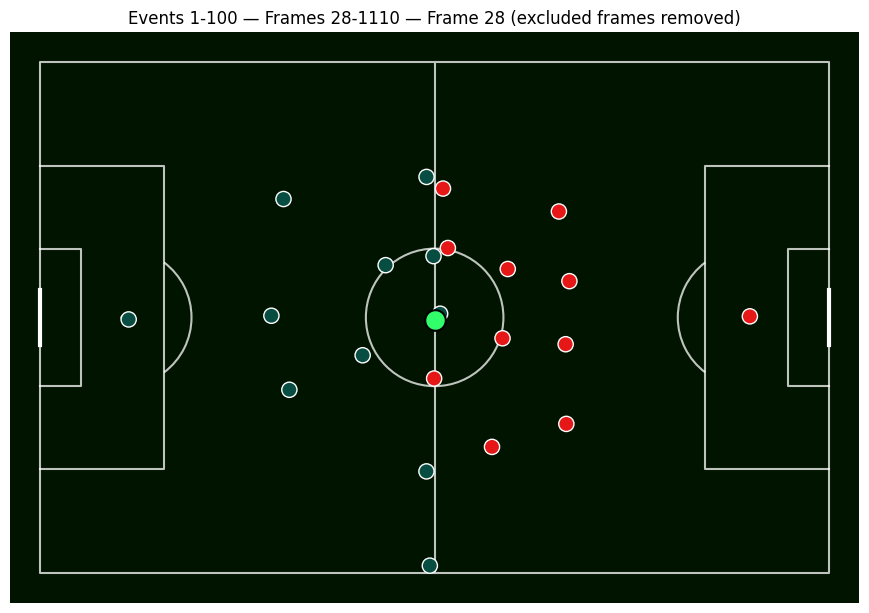

In [23]:
# Animate player positions for the frame range covering the first 24 events
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML, display

# Determine frame range from first 24 events
first_24_events = de_match.head(43)
min_frame = int(first_24_events['frame_start'].min())
max_frame = int(first_24_events['frame_end'].max())

# Subset enriched tracking data for that frame range
subset = enriched_tracking_data[enriched_tracking_data['frame'].between(min_frame, max_frame)]
frames = sorted(subset['frame'].unique())

# Setup pitch and figure
pitch = Pitch(pitch_type="skillcorner", line_alpha=0.75, pitch_length=105, pitch_width=68, pitch_color="#001400", line_color="white", linewidth=1.5)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)

# Color map for teams present in the subset
team_ids = list(subset['team_id'].dropna().unique())
colors_palette = ['#084D42', '#E51717', '#E5BA21', '#32FE6B']
color_map = {tid: colors_palette[i % len(colors_palette)] for i, tid in enumerate(team_ids)}

player_artists = []
ball_artist = None

def update(frame):
    global player_artists, ball_artist
    # remove previous artists
    for art in player_artists:
        try:
            art.remove()
        except Exception:
            pass
    player_artists = []
    if ball_artist is not None:
        try:
            ball_artist.remove()
        except Exception:
            pass
    # gather players for this frame
    df = subset[subset['frame'] == frame]
    if not df.empty:
        cols = [color_map.get(t, '#999999') for t in df['team_id']]
        art = ax.scatter(df['x'], df['y'], c=cols, s=120, edgecolors='white', linewidths=1, zorder=10)
        player_artists.append(art)

    # Find ball position: prefer explicit ball_x/ball_y columns if present
    ball_x = None
    ball_y = None
    if 'ball_x' in tracking_df.columns and 'ball_y' in tracking_df.columns:
        bdf = tracking_df[tracking_df['frame'] == frame][['ball_x', 'ball_y', 'is_detected_ball']]
        if not bdf.empty:
            if 'is_detected_ball' in bdf.columns and bdf['is_detected_ball'].any():
                br = bdf[bdf['is_detected_ball'] == True].iloc[0]
            else:
                br = bdf.iloc[0]
            ball_x, ball_y = br['ball_x'], br['ball_y']
    else:
        # Fallback: some datasets include a ball row with player_id NaN and x,y columns
        if 'player_id' in tracking_df.columns and 'x' in tracking_df.columns and 'y' in tracking_df.columns:
            bdf = tracking_df[(tracking_df['frame'] == frame) & (tracking_df['player_id'].isna())]
            if not bdf.empty:
                br = bdf.iloc[0]
                ball_x, ball_y = br['x'], br['y']

    # Plot ball if found
    global_ax = ax
    if ball_x is not None and not pd.isna(ball_x):
        ball_artist = global_ax.scatter([ball_x], [ball_y], c='#32FE6B', s=220, edgecolors='black', linewidths=1.5, zorder=12)
    else:
        ball_artist = None

    ax.set_title(f'Frames {min_frame}-{max_frame} — Frame {frame}')
    return player_artists + ([ball_artist] if ball_artist is not None else [])

anim = FuncAnimation(fig, update, frames=frames, interval=100, blit=False)

# Try to save as MP4 (requires ffmpeg). If saving fails, fall back to JS animation.
output_path = 'first14_events.mp4'
try:
    writer = FFMpegWriter(fps=10)
    anim.save(output_path, writer=writer)
    print('Saved video to', output_path)
    display(HTML(f"<video controls src='{output_path}' width=900></video>"))
except Exception as e:
    print('Could not save MP4 (ffmpeg may be missing). Falling back to JS animation. Error:', e)
    display(HTML(anim.to_jshtml()))
